Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
3555 matching events found
No baseline correction applied
Using data from preloaded Raw for 3555 events and 497 original time points ...
178 bad epochs dropped


C:\Users\matth\AppData\Local\Temp\ipykernel_1176\1556103970.py:72: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = (epoched.get_data() * 1e3).astype(np.float32)


Reloading Tuner from my_dir\eeg_tuning\tuner0.json
Epoch 1/50
85/85 [==============================] - ETA: 0s - loss: 0.9535 - accuracy: 0.5194

INFO:tensorflow:Assets written to: best_model_tuned\assets


INFO:tensorflow:Assets written to: best_model_tuned\assets


85/85 [==============================] - 26s 256ms/step - loss: 0.9535 - accuracy: 0.5194 - val_loss: 0.8835 - val_accuracy: 0.5266 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - ETA: 0s - loss: 0.9133 - accuracy: 0.5294

INFO:tensorflow:Assets written to: best_model_tuned\assets


INFO:tensorflow:Assets written to: best_model_tuned\assets


85/85 [==============================] - 21s 245ms/step - loss: 0.9133 - accuracy: 0.5294 - val_loss: 0.8704 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 3/50
85/85 [==============================] - 14s 171ms/step - loss: 0.8689 - accuracy: 0.5602 - val_loss: 0.8603 - val_accuracy: 0.5059 - lr: 0.0010
Epoch 4/50
85/85 [==============================] - 15s 174ms/step - loss: 0.8687 - accuracy: 0.5561 - val_loss: 0.8639 - val_accuracy: 0.4911 - lr: 0.0010
Epoch 5/50
85/85 [==============================] - 15s 179ms/step - loss: 0.8312 - accuracy: 0.5776 - val_loss: 0.8608 - val_accuracy: 0.4556 - lr: 0.0010
Epoch 6/50
85/85 [==============================] - 15s 178ms/step - loss: 0.8093 - accuracy: 0.5890 - val_loss: 0.8634 - val_accuracy: 0.4704 - lr: 1.0000e-04
Epoch 7/50
85/85 [==============================] - 15s 180ms/step - loss: 0.8089 - accuracy: 0.5902 - val_loss: 0.8658 - val_accuracy: 0.4675 - lr: 1.0000e-04
Epoch 8/50
85/85 [==============================] - 15s 180ms/step 

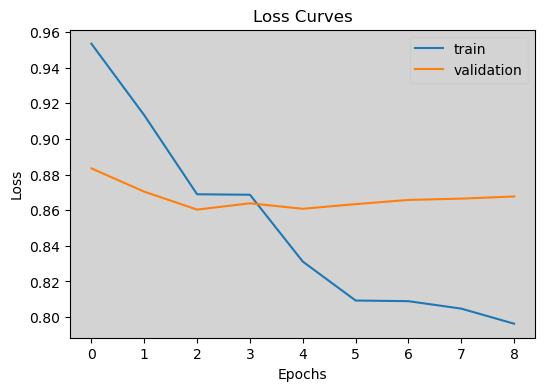

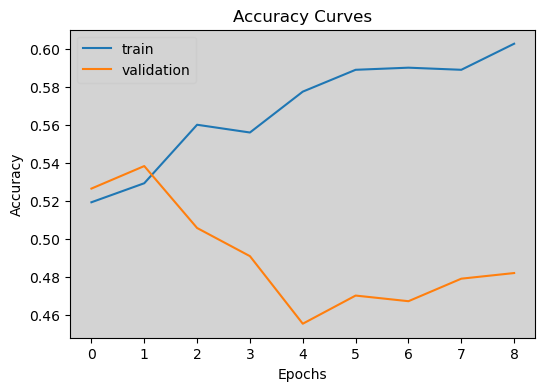

1/1 [==============================] - 0s 29ms/step



Imagining left hand movement!
Ground-truth: right!


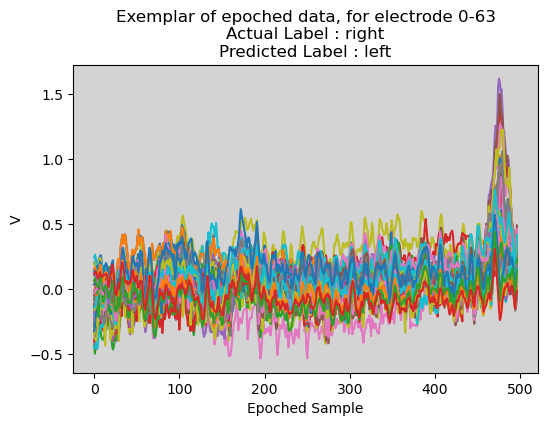

Saved plot as sample_prediction_1.png



1/1 [==============================] - 0s 24ms/step



Imagining left hand movement!
Ground-truth: right!


<Figure size 640x480 with 0 Axes>

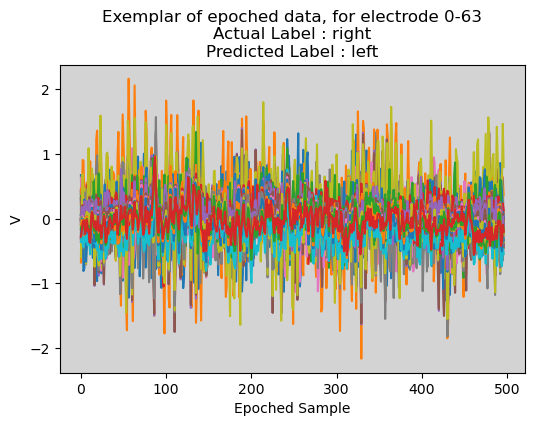

Saved plot as sample_prediction_2.png



1/1 [==============================] - 0s 21ms/step



Imagining left hand movement!
Ground-truth: left!


<Figure size 640x480 with 0 Axes>

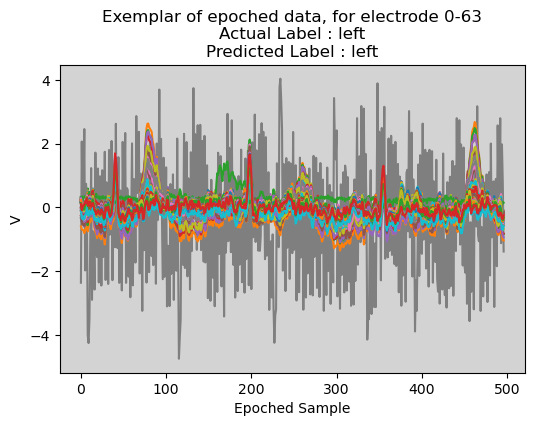

Saved plot as sample_prediction_3.png



1/1 [==============================] - 0s 20ms/step



Imagining left hand movement!
Ground-truth: right!


<Figure size 640x480 with 0 Axes>

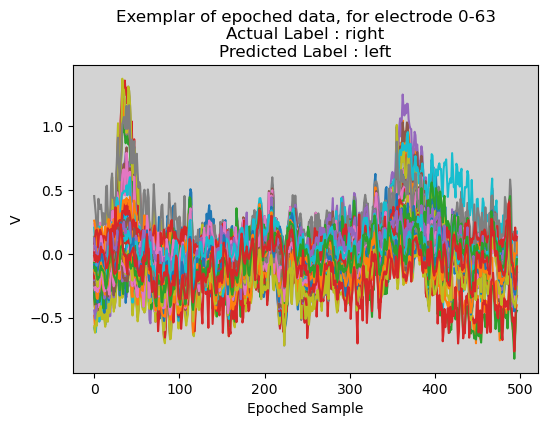

Saved plot as sample_prediction_4.png



1/1 [==============================] - 0s 21ms/step



Imagining left hand movement!
Ground-truth: right!


<Figure size 640x480 with 0 Axes>

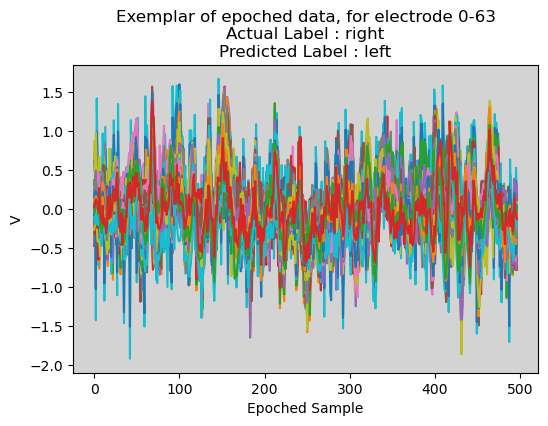

Saved plot as sample_prediction_5.png





<Figure size 640x480 with 0 Axes>

In [1]:
# Importing necessary libraries
import mne
import os
import re
import io
import cv2
import random
import string
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
import keras_tuner as kt

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'

# Loading EEG Motor Movement/Imagery Dataset
N_SUBJECT = 109
IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST = [4, 8, 12]

physionet_paths = [
    mne.datasets.eegbci.load_data(
        id,
        IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST,
        "/Users/matth/Downloads/eeg-motor-imagery-classification-master",
    )
    for id in range(1, (N_SUBJECT - 30) + 1) # pick 1 to 79
]
physionet_paths = np.concatenate(physionet_paths)

parts = [
    mne.io.read_raw_edf(
        path,
        preload=True,
        stim_channel='auto',
        verbose='WARNING',
    )
    for path in physionet_paths
]

raw = mne.io.concatenate_raws(parts)
events, _ = mne.events_from_annotations(raw)

eeg_channel_inds = mne.pick_types(
    raw.info,
    meg=False,
    eeg=True,
    stim=False,
    eog=False,
    exclude='bads',
)

epoched = mne.Epochs(
    raw,
    events,
    dict(left=2, right=3),
    tmin=1,
    tmax=4.1,
    proj=False,
    picks=eeg_channel_inds,
    baseline=None,
    preload=True
)

X = (epoched.get_data() * 1e3).astype(np.float32)
y = (epoched.events[:, 2] - 2).astype(np.int64)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Hyperparameter tuning function
def build_model(hp):
    model = models.Sequential()
    
    # Convolutional layers with hyperparameter tuning
    model.add(layers.Conv1D(filters=hp.Int('conv_filters', min_value=16, max_value=64, step=16), 
                            kernel_size=hp.Choice('kernel_size', values=[7, 11]), 
                            padding='same', 
                            activation='relu', 
                            kernel_regularizer=regularizers.l2(0.001), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Additional Conv Layer
    model.add(layers.Conv1D(filters=hp.Int('conv_filters_2', min_value=32, max_value=128, step=32), 
                            kernel_size=hp.Choice('kernel_size_2', values=[5, 7]), 
                            padding='same', 
                            activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_rate_2', min_value=0.2, max_value=0.5, step=0.1)))

    # Bidirectional LSTM with residual connections
    model.add(layers.Bidirectional(layers.LSTM(units=hp.Int('lstm_units', min_value=16, max_value=64, step=16), return_sequences=True)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_rate_3', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(layers.Bidirectional(layers.LSTM(units=hp.Int('lstm_units_2', min_value=8, max_value=32, step=8))))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_rate_4', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Fully connected layers
    model.add(layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), 
                           activation='relu', 
                           kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(hp.Float('dropout_rate_5', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Hyperparameter tuner
tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=20,
                        executions_per_trial=2,
                        directory='my_dir',
                        project_name='eeg_tuning')

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[callbacks.EarlyStopping(patience=5)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50, 
                    batch_size=32, 
                    callbacks=[callbacks.ModelCheckpoint("best_model_tuned", save_best_only=True, monitor="val_accuracy", mode="max"),
                               callbacks.EarlyStopping(patience=7, restore_best_weights=True, monitor="val_accuracy", mode="max"),
                               callbacks.CSVLogger("training_log_tuned.csv"),
                               callbacks.ReduceLROnPlateau(factor=0.1, patience=3, monitor="val_accuracy", mode="max")])

# Evaluate the model on the test set
model = tf.keras.models.load_model("best_model_tuned")

y_pred = (model.predict(X_test) > 0.5).astype("int32")
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

import os

# Ensure the directory to save the plots exists
output_dir = "output_plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Plotting the loss and accuracy curves and saving them as separate files
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(output_dir, "loss_curve.png"))
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title("Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(output_dir, "accuracy_curve.png"))
plt.show()

# Sample predictions as separate outputs and saving each
for i in range(5):
    sample_idx = random.randint(0, X_test.shape[0] - 1)
    sample = X_test[sample_idx]
    prediction = model.predict(np.expand_dims(sample, axis=0))
    predicted_class = "left" if prediction < 0.5 else "right"
    actual_class = "left" if y_test[sample_idx] == 0 else "right"
    
    print(f"\n\n\nImagining {predicted_class} hand movement!")
    print(f"Ground-truth: {actual_class}!")
    
    plt.figure(figsize=(6, 4))
    plt.plot(sample.T)
    plt.title(f"Exemplar of epoched data, for electrode 0-63\nActual Label : {actual_class}\nPredicted Label : {predicted_class}")
    plt.ylabel("V")
    plt.xlabel("Epoched Sample")
    filename = f"sample_prediction_{i+1}.png"
    plt.savefig(os.path.join(output_dir, filename))
    plt.show()
    plt.clf()

    print(f"Saved plot as {filename}\n\n\n")

